In [1]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

/anaconda3/envs/azmlenv/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)
/anaconda3/envs/azmlenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [5]:
from azureml.core import Workspace
ws = Workspace.create(name='mymlworkspace',
                      subscription_id='1e30ba0a-66fa-4479-9bca-95ba2cf71b20',    
                      resource_group='mymlexp',
                      create_resource_group=False,
                      location='eastus2' # or other supported Azure region  
                     )

In [6]:
ws.get_details()

{'applicationInsights': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/mymlexp/providers/microsoft.insights/components/mymlworkinsightstvpmhgzd',
 'batchaiWorkspace': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/mymlexp/providers/microsoft.batchai/workspaces/mymlworkbatchai_lhlsmuif',
 'containerRegistry': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/mymlexp/providers/microsoft.containerregistry/registries/mymlworkacregoazejb',
 'description': '',
 'friendlyName': 'mymlworkspace',
 'id': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourceGroups/mymlexp/providers/Microsoft.MachineLearningServices/workspaces/mymlworkspace',
 'identityPrincipalId': '4aa3ad3f-d04a-47d7-bab4-a86f3521fb8f',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47',
 'identityType': 'SystemAssigned',
 'keyVault': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/mymlexp/providers/microsoft.keyvault/vaults/mymlwork

In [7]:
# Create the configuration file.
ws.write_config()

# Use this code to load the workspace from 
# other scripts and notebooks in this directory.
# ws = Workspace.from_config()

Wrote the config file config.json to: /Users/trinakarmakar/codelibs/aml_config/config.json


In [8]:
ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'automl-classifier'
# project folder
project_folder = './automl-classifier'

import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: /Users/trinakarmakar/codelibs/aml_config/config.json


,
Location,eastus2
Project Directory,./automl-classifier
Resource Group,mymlexp
SDK version,0.1.74
Subscription ID,1e30ba0a-66fa-4479-9bca-95ba2cf71b20
Workspace,mymlworkspace


In [9]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

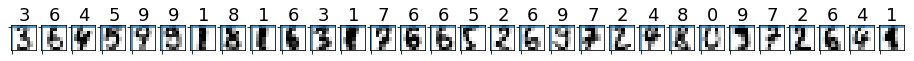

In [10]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 2, y = -2, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(8, 8), cmap = plt.cm.Greys)
plt.show()

In [11]:
from azureml.train.automl import AutoMLConfig

##Local compute 
Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             max_time_sec = 12000,
                             iterations = 20,
                             n_cross_validations = 3,
                             exit_score = 0.9985,
                             blacklist_algos = ['kNN','LinearSVM'],
                             X = X_train,
                             y = y_train,
                             path=project_folder)

In [12]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_7a5b8a82-ea77-4054-baf3-362fd1ef16e9
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      StandardScalerWrapper KNeighborsClassi0:00:08.300600           0.999     0.999
Stopping criteria reached at iteration 1. Ending experiment.

In [13]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

In [14]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0
AUC_macro,0.998831
AUC_micro,0.999016
AUC_weighted,0.998831
AUC_weighted_max,0.998831
accuracy,0.965236
average_precision_score_macro,0.993350
average_precision_score_micro,0.994107
average_precision_score_weighted,0.993454
balanced_accuracy,0.965062
f1_score_macro,0.965093


In [15]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

# register model in workspace
description = 'Automated Machine Learning Model'
tags = None
local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azure

Registering model AutoML7a5b8a82ebest


'AutoML7a5b8a82ebest'

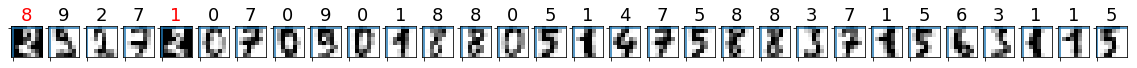

In [16]:
# find 30 random samples from test set
n = 30
X_test = digits.data[:100, :]
y_test = digits.target[:100]
sample_indices = np.random.permutation(X_test.shape[0])[0:n]
test_samples = X_test[sample_indices]


# predict using the  model
result = fitted_model.predict(test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x = 2, y = -2, s = result[i], fontsize = 18, color = font_color)
    plt.imshow(X_test[s].reshape(8, 8), cmap = clr_map)
    
    i = i + 1
plt.show()